Hypothesis: the model optimizations (force-consider; graph-normalization; and both) do not affect the payoff of the optimal policy

Fact: The policy itself is affected as state and action spaces are not the same after applying the optimizations.

Plan: Take the models with fixed exploration depth, solve MDPs compare results.

Note: In principle we should check this for various gammas and alphas.

In [1]:
import gzip
import pandas
import pickle
import seaborn
import tqdm

from lib.models.aft20barzur import ptmdp
from lib.models.generic_v0.model import map_params

In [2]:
mdps = pandas.read_pickle("4-generated-mdps/fixed.pkl.gz")
mdps

,scenario,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,protocol,depth,size,time_spent,rss,mdp
0,reference,fc16sapirshtein,True,True,True,True,bitcoin,4,35,0.140762,0.108421,65bc2718
1,baseline,generic_1,False,False,True,True,bitcoin,4,4134,2.110153,0.334702,2b6b898d
2,baseline,generic_1,False,False,True,True,ethereum_3,4,12624,11.949178,0.355598,5a549c09
3,baseline,generic_1,False,False,True,True,byzantium_3,4,12626,12.929234,0.360600,64855e99
4,baseline,generic_1,False,False,True,True,ghostdag_3,4,18127,24.662831,0.364323,6e69c992
5,baseline,generic_1,False,False,True,True,parallel_3,4,44954,30.200049,0.599926,5ab131aa
6,w/ force consider,generic_1,True,False,True,True,bitcoin,4,878,4.315543,0.447296,31736a8c
7,w/ force consider,generic_1,True,False,True,True,ethereum_3,4,8436,13.079722,0.385059,69fa69d8
8,w/ force consider,generic_1,True,False,True,True,byzantium_3,4,8340,13.963664,0.380177,10e9eac3
9,w/ force consider,generic_1,True,False,True,True,ghostdag_3,4,2670,8.786848,0.382423,26ed4335


In [3]:
networks = []
# for alpha in range(5, 51, 5):
for alpha in range(35, 41, 5):
    for gamma in [0.33, 0.66]:
        # for gamma in [0, 0.5, 1]:
        networks.append(dict(alpha=alpha / 100, gamma=gamma))
# pandas.DataFrame(networks)

In [4]:
horizon = 10
stop_delta = (
    0.0001  # value iteration stops when no value estimate changes more than this value
)

with tqdm.tqdm(total=len(networks) * len(mdps)) as pbar:
    rows = []
    for network in networks:
        for i, row in mdps.iterrows():
            with gzip.open(f"4-generated-mdps/mdp-{row.mdp}.pkl.gz", "rb") as f:
                emdp = pickle.load(f)
            emdp = map_params(emdp, **network)
            emdp = ptmdp(emdp, horizon=horizon)
            vi = emdp.value_iteration(discount=1, stop_delta=stop_delta)
            policy = vi.pop("vi_policy")
            state_fut_reward = vi.pop("vi_value")
            state_fut_progress = vi.pop("vi_progress")

            episode_reward = 0
            episode_progress = 0
            for state, prb in emdp.start.items():
                episode_reward += prb * state_fut_reward[state]
                episode_progress += prb * state_fut_progress[state]

            res = dict(
                episode_reward=episode_reward,
                episode_progress=episode_progress,
                _episode_reward_per_progress=episode_reward
                / episode_progress,  # progress is already accounted for via ptmdp/horizon
            )

            rows.append(row.to_dict() | network | vi | res)

            pbar.update(1)

df = pandas.DataFrame(rows)
df

100%|███████████████████████████████████████████| 84/84 [12:02<00:00,  8.60s/it]


,scenario,model,force_consider_own,merge_isomorphic,truncate_common_chain,collect_garbage,protocol,depth,size,time_spent,...,gamma,vi_discount,vi_delta,vi_stop_delta,vi_iter,vi_max_iter,vi_time,episode_reward,episode_progress,_episode_reward_per_progress
0,reference,fc16sapirshtein,True,True,True,True,bitcoin,4,35,0.140762,...,0.33,1,0.000097,0.0001,99,0,0.017723,3.854739,10.374745,0.371550
1,baseline,generic_1,False,False,True,True,bitcoin,4,4134,2.110153,...,0.33,1,0.000100,0.0001,212,0,2.133697,3.704303,10.172048,0.364165
2,baseline,generic_1,False,False,True,True,ethereum_3,4,12624,11.949178,...,0.33,1,0.000097,0.0001,247,0,8.674523,4.700272,10.018647,0.469152
3,baseline,generic_1,False,False,True,True,byzantium_3,4,12626,12.929234,...,0.33,1,0.000100,0.0001,186,0,6.710022,3.650537,10.262174,0.355727
4,baseline,generic_1,False,False,True,True,ghostdag_3,4,18127,24.662831,...,0.33,1,0.000100,0.0001,174,0,9.381966,3.689516,10.433520,0.353621
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79,w/ both,generic_1,True,True,True,True,bitcoin,4,319,5.706475,...,0.66,1,0.000099,0.0001,225,0,0.238037,5.020921,10.233443,0.490638
80,w/ both,generic_1,True,True,True,True,ethereum_3,4,2111,8.291489,...,0.66,1,0.000096,0.0001,231,0,1.530581,5.453167,10.160581,0.536698
81,w/ both,generic_1,True,True,True,True,byzantium_3,4,2081,8.623618,...,0.66,1,0.000097,0.0001,197,0,1.255784,4.766218,10.384025,0.458995
82,w/ both,generic_1,True,True,True,True,ghostdag_3,4,827,7.279270,...,0.66,1,0.000097,0.0001,161,0,0.425408,4.251536,10.556247,0.402751


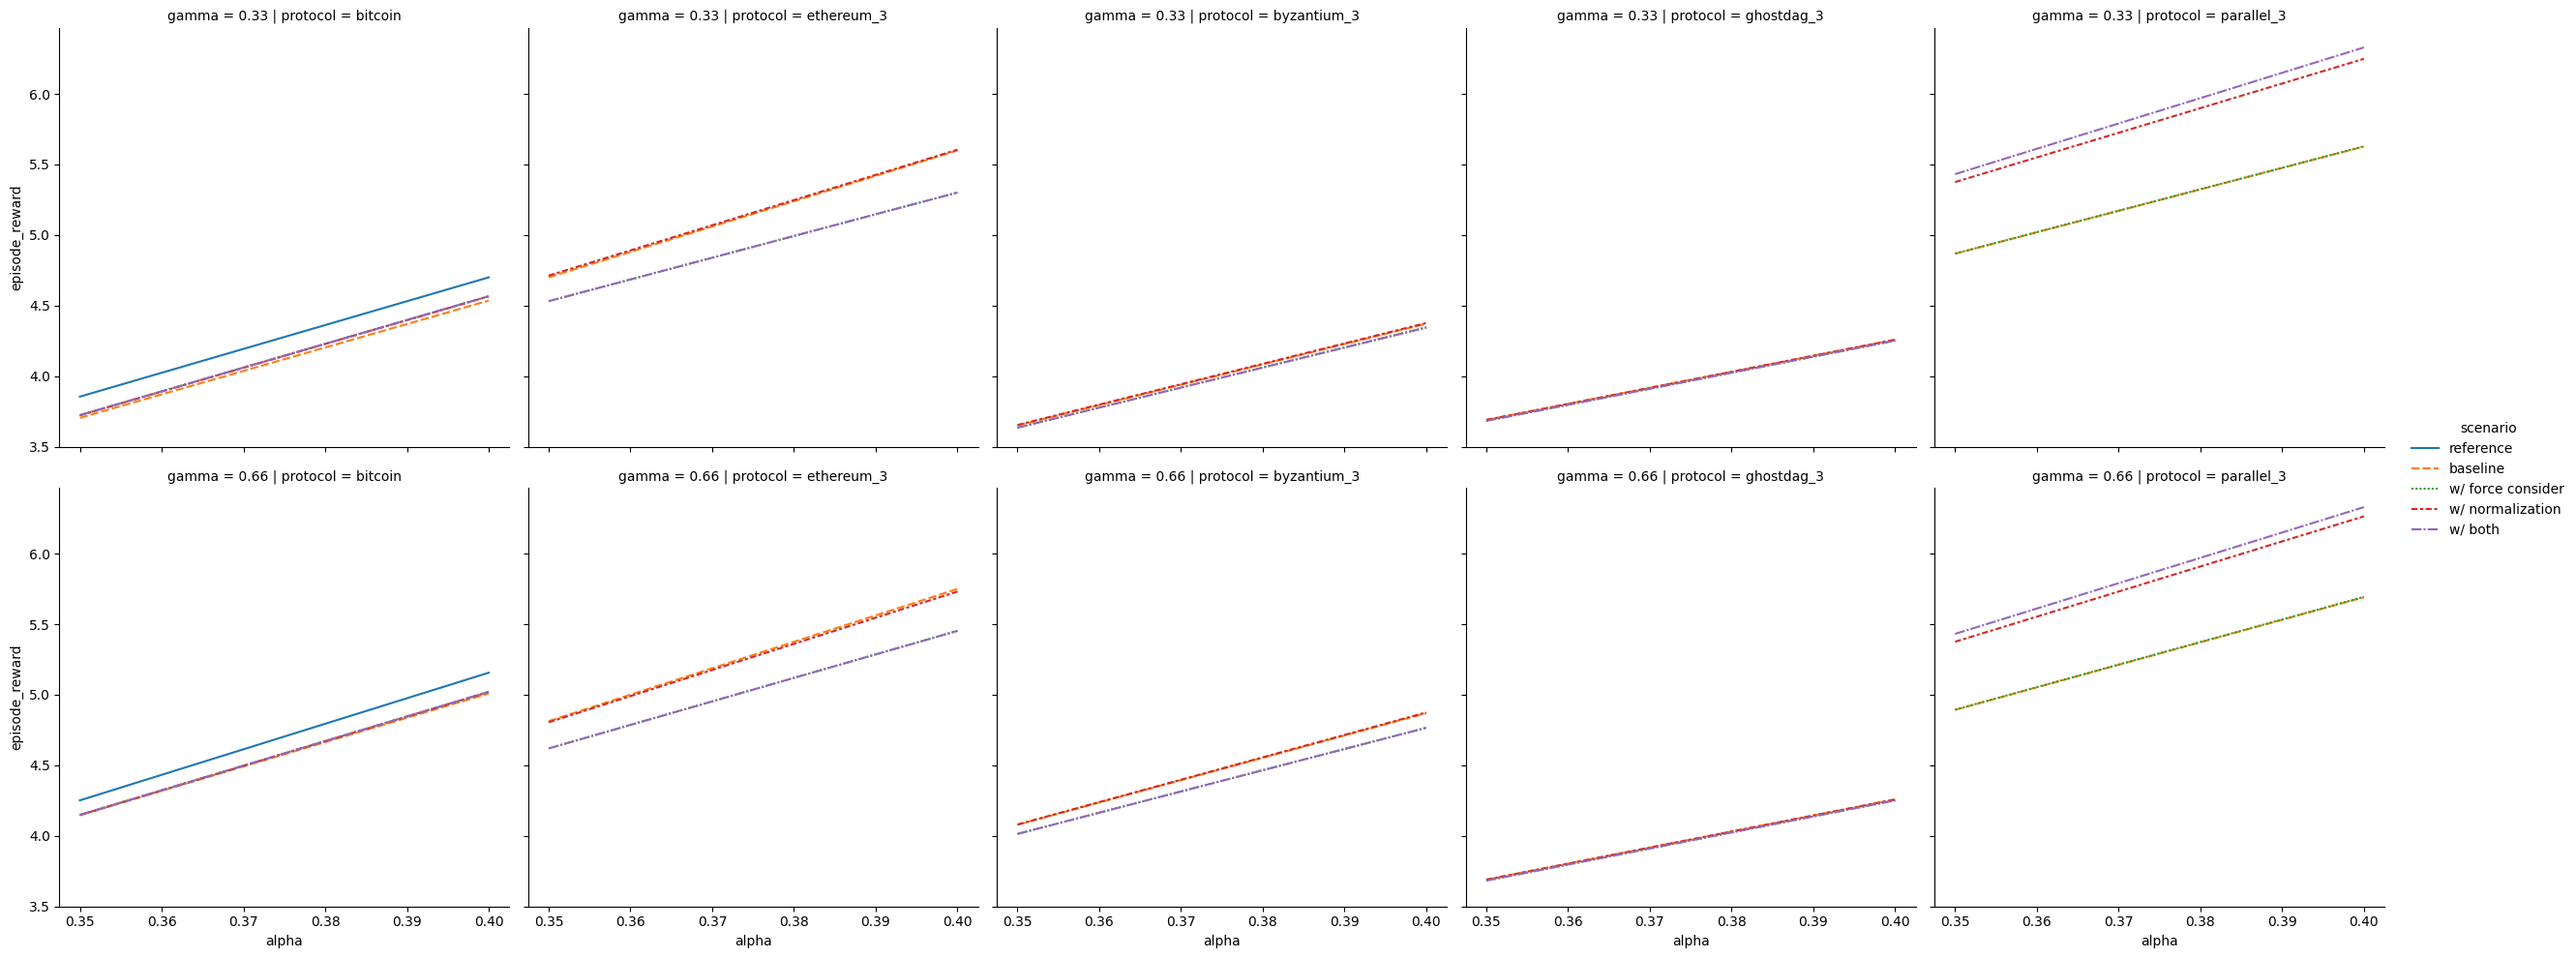

In [13]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_reward",
    col="protocol",
    hue="scenario",
    style="scenario",
    row="gamma",
)

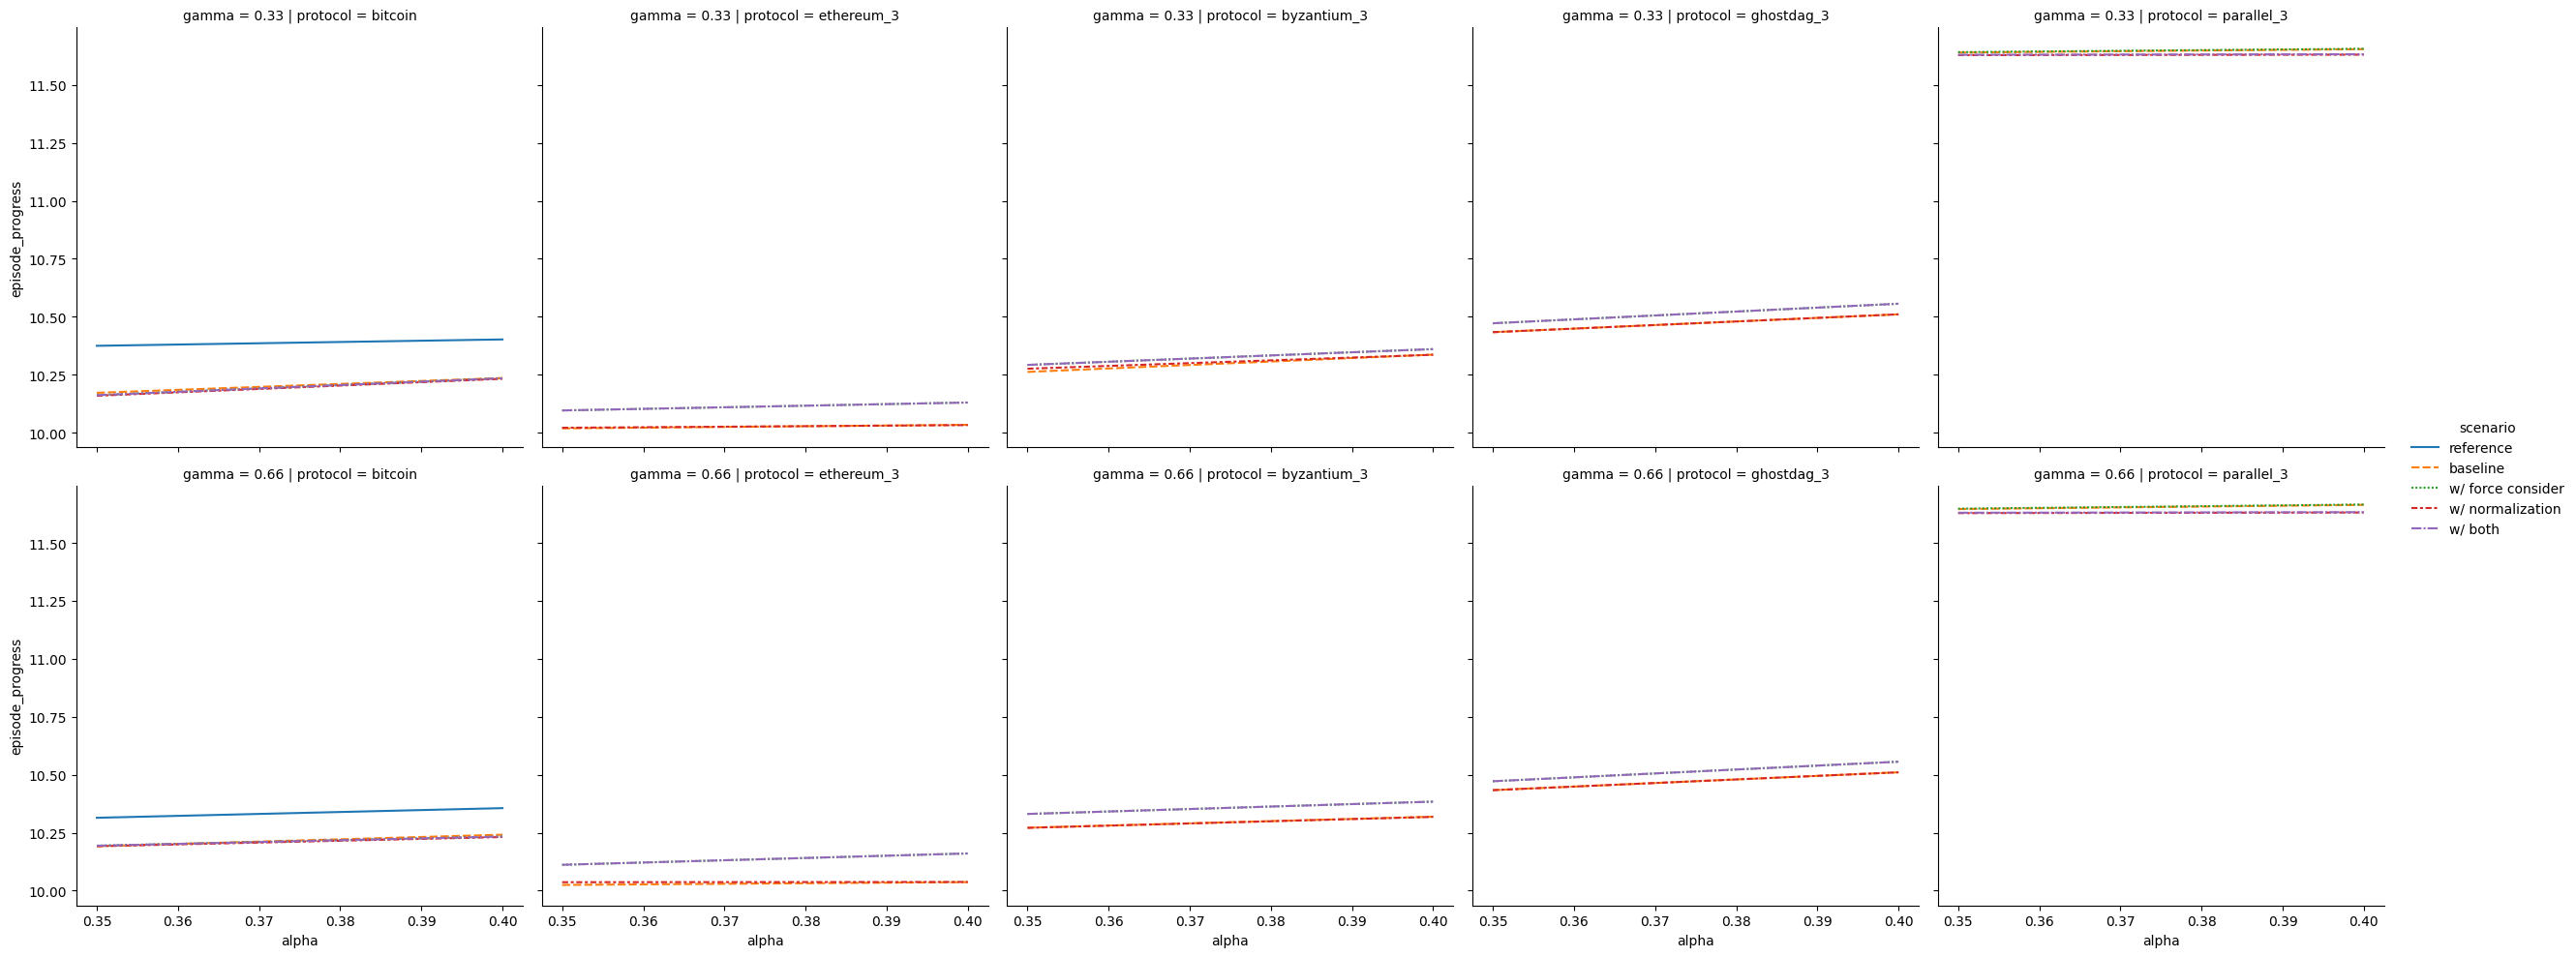

In [14]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="episode_progress",
    col="protocol",
    hue="scenario",
    style="scenario",
    row="gamma",
)

It currently looks like the optimizations would introduce subtle differences to the MDPs.

Bitcoin and GhostDAG are not affected. Ethereum, Parallel, Byzantium are.

I'll have to investigate which optimization is triggering this and why. Is it about the optimizations, really? Or maybe the attack search?

Hypothesis: DAG normalization is the sole cause of the split

Logic: Assume hypothesis. w/both and w/normalization should behave the same; w/force-consider and baseline should behave the same.

Observations: This seems to be true for Parallel, but not Ethereum/Byzantium.

Hypothesis: value iteration is not finished properly.

Test: I'll try to reduce the horizon to something very small.

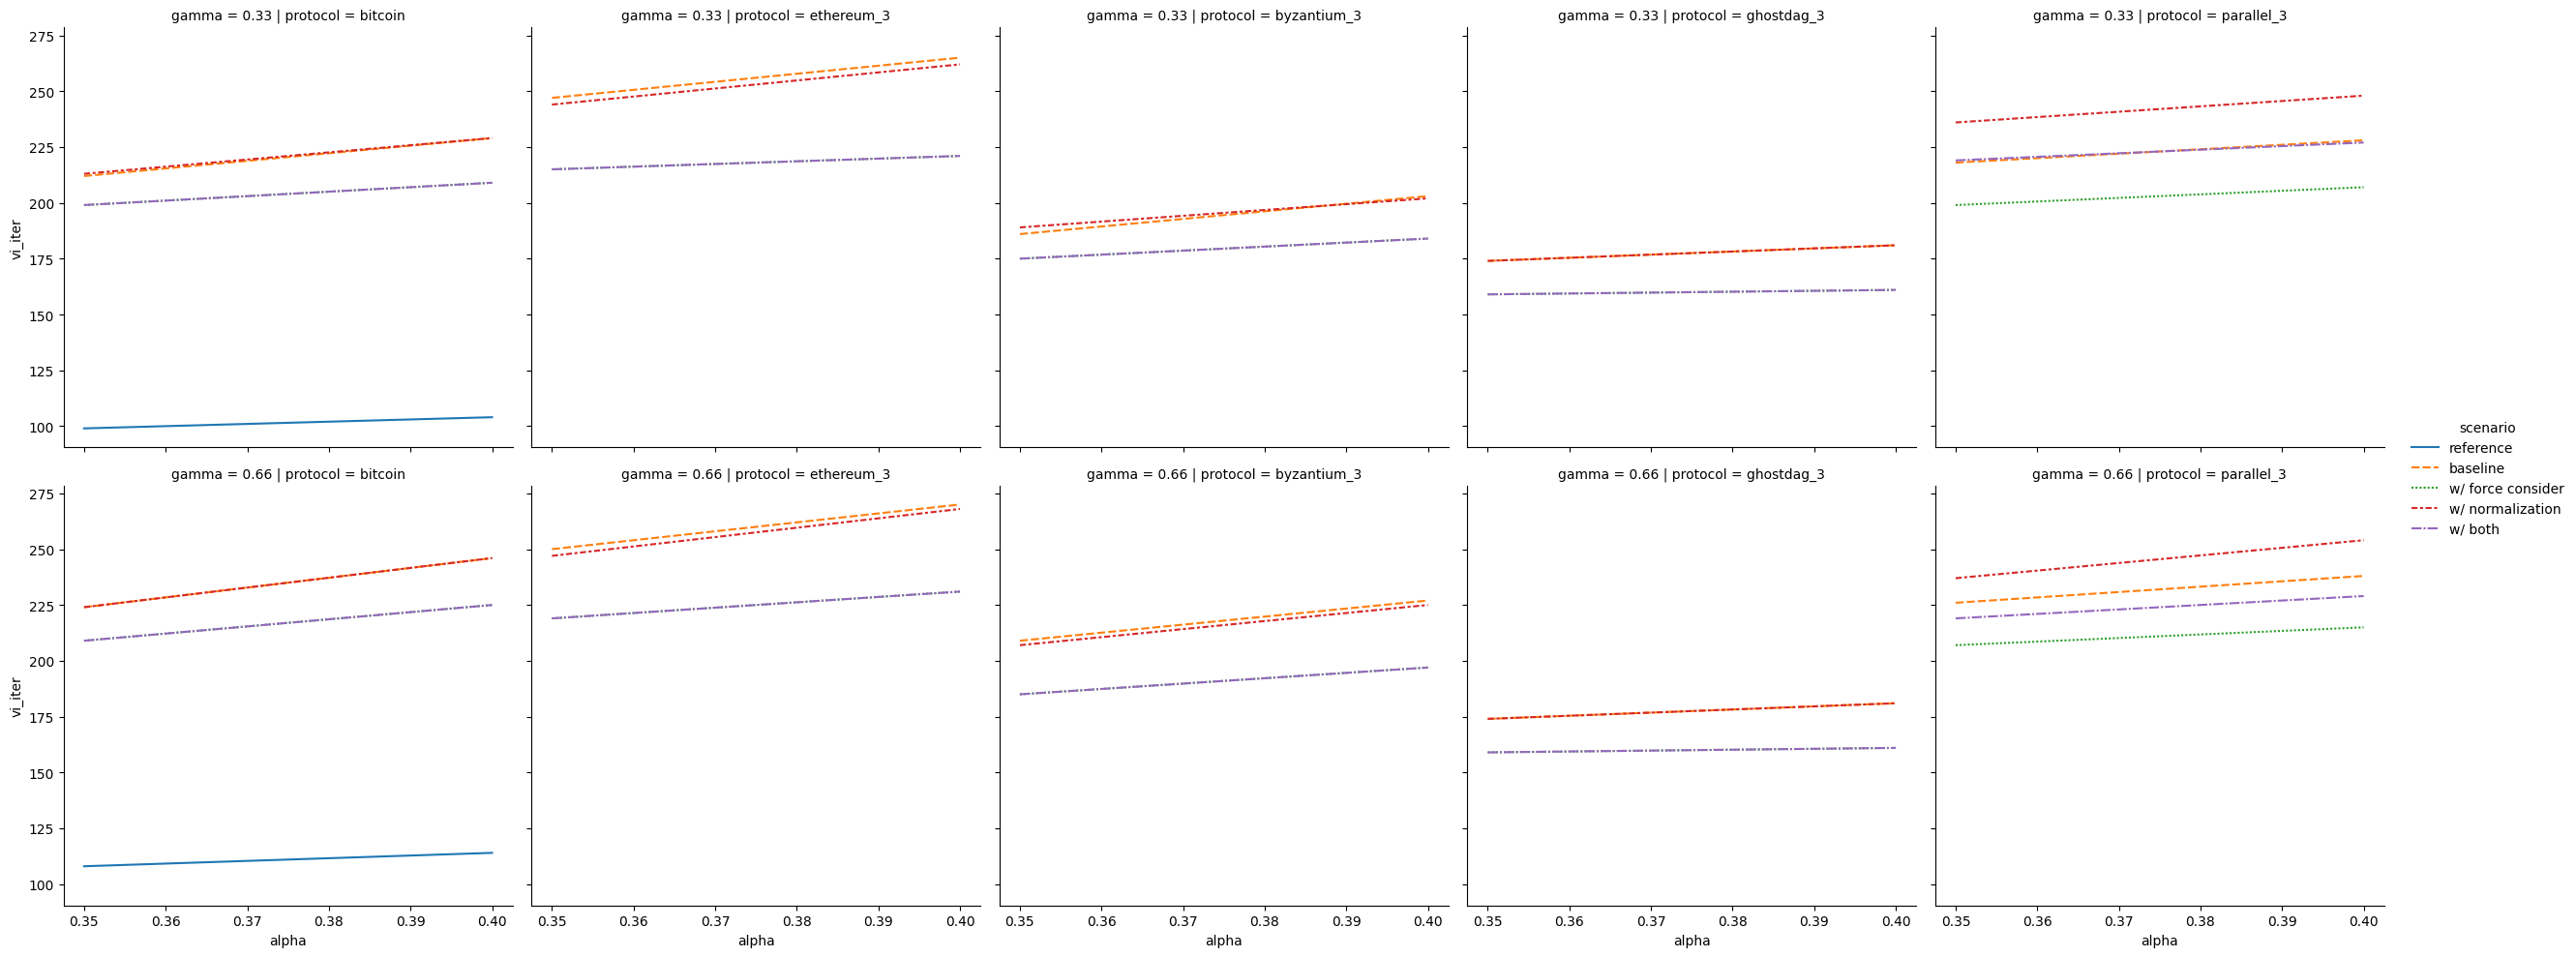

In [15]:
seaborn.relplot(
    data=df,
    kind="line",
    x="alpha",
    y="vi_iter",
    col="protocol",
    hue="scenario",
    style="scenario",
    row="gamma",
)

# Stop condition for value iteration

An *approved* stop condition for $\varepsilon$-optimal policy with `discount` factor:

```python
stop_delta = eps * ( 1 - discount ) / discount
```

Now, what is our discount factor? We're discounting for progress (PT MDP) and depending on the horizon.
The termination probability for horizon `H` and progress `Dt` is:

```python
term_prob = 1.0 - ((1.0 - (1.0 / H)) ** Dt)
```

I think our termination probability is somewhat similar to `(1 - discount)` in the infinite horizon value iteration. **(can it?)**

Let's tabulate this to get a feeling

In [8]:
H = 10
Dt = range(0, 4)
term_prob = [1.0 - ((1.0 - (1.0 / H)) ** p) for p in Dt]
pseudo_discount = [1 - tp for tp in term_prob]
[(1 - discount) / discount for discount in pseudo_discount]  # stop_delta / eps

[0.0, 0.11111111111111108, 0.23456790123456783, 0.37174211248285305]

So the smallest progress drives the stop delta. That's cool, because I think the smallest non-zero progress should be one in all protocols. **(checked below)**.

What is our $\varepsilon$?

The horizon scales the expected reward linearly. Max reward equals horizon. If we increase the horizon we can also increase the epsilon to stay at the same precision.

In [9]:
digits_precision = 3
H = [10, 100, 1000]
eps = [h / (10**digits_precision) for h in H]
eps

[0.01, 0.1, 1.0]

In [12]:
def stop_delta(horizon, digits_precision, min_progress=1):
    tp = 1.0 - ((1.0 - (1.0 / horizon)) ** min_progress)
    pd = 1 - tp
    eps = horizon / (10**digits_precision)
    return eps * (1 - pd) / pd


[stop_delta(h, 3) for h in [10, 100, 1000]]

[0.00011111111111111109, 0.00010101010101010109, 0.0001001001001001002]

So, no matter how we scale the horizon, the stop delta can be around 0.001 if we want 3 digit precision.

Now, it seems the observed errors above are _much_ higher.

# Minimum progress

The above assumes `min_progess = 1`. Let's see whether this is true.

In [11]:
rows = []
for i, row in mdps.iterrows():
    with gzip.open(f"4-generated-mdps/mdp-{row.mdp}.pkl.gz", "rb") as f:
        emdp = pickle.load(f)

    min_prg = 10000
    min_prg_nonzero = 10000
    max_prg = 0
    for state_actions in emdp.tab:
        for action_transitions in state_actions:
            for transition in action_transitions:
                min_prg = min(min_prg, transition.progress)
                max_prg = max(max_prg, transition.progress)
                if transition.progress > 0:
                    min_prg_nonzero = min(min_prg_nonzero, transition.progress)

    rows.append(
        row.to_dict()
        | dict(max_prg=max_prg, min_prg=min_prg, min_prg_nonzero=min_prg_nonzero)
    )

prg_check = pandas.DataFrame(rows)
assert prg_check.min_prg.min() >= 0
assert prg_check.min_prg_nonzero.min() >= 1